In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix
import re

In [74]:
data = pd.read_csv('C:\\Users\\ksn\\archive\\rating_complete.csv')
data_100000 = data[-100000:]
print(len(data))
data.head(2)

57633278


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5


In [75]:
data_mal = pd.read_csv('C:\\Users\\ksn\\archive\\anime.csv')
data_mal.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [76]:
data_train = data
me = pd.read_csv('400000.csv')

In [77]:
genres = []

for i in range(len(data_mal)):
    genres.extend(data_mal.iloc[i]['Genres'].split(', '))

colms = list(set(genres))

data_genres = pd.DataFrame(columns=colms)
data_genres['anime_id'] = data_mal['MAL_ID']
data_genres = data_genres.fillna(0)

for i in range(len(data_mal)):
    list_genres = data_mal.loc[i]['Genres'].split(', ')
    for j in list_genres:
        data_genres.at[i, j] = 1
        
data_genres.head(3)

,Space,School,Drama,Unknown,Yaoi,Historical,Adventure,Comedy,Vampire,Fantasy,...,Mecha,Psychological,Shounen Ai,Josei,Sci-Fi,Military,Shoujo Ai,Kids,Super Power,anime_id
0,1,0,1,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,5
2,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,6


In [78]:
for i in range(len(data_genres)):
    try:
        data_genres.at[i, 'year'] = int(re.findall('[0-9]{4}', str(data_mal.loc[data_mal['MAL_ID'] == data_genres.iloc[i]['anime_id']]['Aired'].values[0]))[0])
    except IndexError:
        data_genres.at[i, 'year'] = 9999

In [79]:
data_genres.head(3)

,Space,School,Drama,Unknown,Yaoi,Historical,Adventure,Comedy,Vampire,Fantasy,...,Psychological,Shounen Ai,Josei,Sci-Fi,Military,Shoujo Ai,Kids,Super Power,anime_id,year
0,1,0,1,0,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,1998.0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,5,2001.0
2,0,0,1,0,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,6,1998.0


In [80]:
my_type = data_mal.loc[data_mal['Type'] == 'TV']['MAL_ID'].values.tolist()
data_train = data_train.loc[data_train['anime_id'].isin(my_type)]
data_genres = data_genres.loc[data_genres['anime_id'].isin(my_type)]

my_genres = data_genres.loc[(data_genres['School'] == 1)\
                |(data_genres['Comedy'] == 1)\
                |(data_genres['Music'] == 1)\
                |(data_genres['Parody'] == 1)\
                |(data_genres['Sci-Fi'] == 1)\
                |(data_genres['Fantasy'] == 1)\
                |(data_genres['Slice of Life'] == 1)]['anime_id'].values.tolist()
data_train = data_train.loc[data_train['anime_id'].isin(my_genres)]
data_genres = data_genres.loc[data_genres['anime_id'].isin(my_genres)]

my_year = data_genres.loc[data_genres['year'] > 2000]['anime_id'].values.tolist()
data_train = data_train.loc[data_train['anime_id'].isin(my_year)]
data_genres = data_genres.loc[data_genres['anime_id'].isin(my_year)]

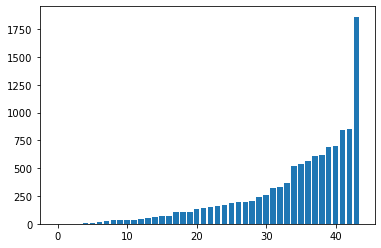

In [81]:
list_sum_col = []
for i in data_genres.columns:
    if i != 'anime_id' and i != 'year':
        list_sum_col.append(sum(data_genres[i]))
    
plt.bar([i for i in range(len(list_sum_col))], height=sorted(list_sum_col))
plt.show()

In [82]:
for i in data_genres.columns:
    if i != 'anime_id' and sum(data_genres[i]) < 300:
        data_genres.drop(i, axis=1, inplace=True)

data_genres.columns

Index(['School', 'Drama', 'Adventure', 'Comedy', 'Fantasy', 'Supernatural',
       'Magic', 'Shounen', 'Action', 'Slice of Life', 'Romance', 'Sci-Fi',
       'Kids', 'anime_id', 'year'],
      dtype='object')

In [83]:
len(data_train)

31530423

### 1st level

In [84]:
popularity_anime = data_train.groupby('anime_id')['rating'].sum().reset_index().sort_values('rating', ascending=False)
popularity_anime.head(3)

,anime_id,rating
1314,16498,1445712
762,5114,1239579
398,1575,1203768


In [85]:
# top_anime = popularity_anime.reset_index(drop=True)[:10000]
# top_anime = top_anime['anime_id'].tolist()

In [86]:
popularity_anime = popularity_anime.reset_index(drop=True)
popularity_anime['rating_rank'] = popularity_anime.index
popularity_anime.drop('rating', axis=1, inplace=True)
popularity_anime.head(3)

,anime_id,rating_rank
0,16498,0
1,5114,1
2,1575,2


In [87]:
data_train = pd.merge(data_train, popularity_anime, how='left', on='anime_id')

In [88]:
data_train.head(3)

,user_id,anime_id,rating,rating_rank
0,0,1571,10,418
1,0,121,9,22
2,0,356,9,61


In [89]:
user_rating = data_train.groupby('user_id')['rating_rank'].sum().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_rating.head(3)

,user_id,rating_rank
0,189037,3912321
1,68042,3656817
2,162615,3516085


In [90]:
user_val = data_train.groupby('user_id')['rating_rank'].count().reset_index().sort_values('rating_rank', ascending=False).reset_index(drop=True)
user_val.head(3)

,user_id,rating_rank
0,189037,2768
1,68042,2667
2,162615,2507


In [91]:
user_rating = pd.merge(user_rating, user_val, how='left', on='user_id')
user_rating['rating_rank'] = user_rating['rating_rank_x']/user_rating['rating_rank_y']
user_rating.drop(['rating_rank_x', 'rating_rank_y'], axis=1, inplace=True)
user_rating.head(3)

,user_id,rating_rank
0,189037,1413.410766
1,68042,1371.134983
2,162615,1402.506980


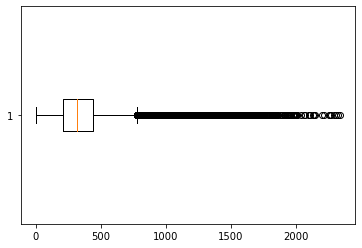

In [92]:
plt.boxplot(user_rating['rating_rank'], vert=False)
plt.show()

In [93]:
user_rating = user_rating.loc[(user_rating['rating_rank'] < 12000) & (user_rating['rating_rank'] > 600)]

In [94]:
user_list = user_rating['user_id'].tolist()

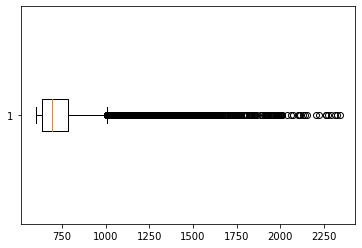

In [95]:
plt.boxplot(user_rating['rating_rank'], vert=False)
plt.show()

In [96]:
# data_train = data_train.loc[data_train['anime_id'].isin(top_anime)]
# data_train.head(3)

In [97]:
data_train = data_train.loc[data_train['user_id'].isin(user_list)]
data_train = pd.concat([data_train, me], ignore_index=True)
len(data_train)

4675688

In [98]:
len(data_train.groupby('user_id')), len(data_train.groupby('anime_id'))

(25342, 2882)

In [99]:
import pandas as pd
import numpy as np

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight


class MainRecommender:
    """Рекоммендации, которые можно получить из ALS"""

    def __init__(self, data, weighting=True):
        # your_code. Это не обязательная часть. Но если вам удобно что-либо посчитать тут - можно это сделать

        self.user_item_matrix = self.prepare_matrix(data)  # pd.DataFrame
        self.id_to_itemid, self.id_to_userid, self.itemid_to_id, self.userid_to_id = self.prepare_dicts(
            self.user_item_matrix)
        self.top100 = self.top_100(data)

        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T

        self.model_als = self.fit_als(self.user_item_matrix)
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)
        self.similar_users_recommender = self.fit_similar_users_recommender(self.user_item_matrix)


    @staticmethod
    def top_100(data):
        popularity = data.groupby('anime_id')['rating'].sum().reset_index()
        top_100 = popularity.sort_values('rating', ascending=False).head(100).anime_id.tolist()
        return top_100


    @staticmethod
    def prepare_matrix(data):
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id', columns='anime_id',
                                          values='rating',
                                          fill_value=0)
        
        user_item_matrix = user_item_matrix.astype(float)  # необходимый тип матрицы для implicit

        return user_item_matrix

    @staticmethod
    def prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id


    @staticmethod
    def fit_own_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных юзером"""
        own_recommender = ItemItemRecommender(K=10, num_threads=0)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())

        return own_recommender


    @staticmethod
    def fit_als(user_item_matrix):
        """Обучает ALS"""

        model = AlternatingLeastSquares(factors=200,
                                        regularization=0.01,
                                        iterations=20,
                                        num_threads=0,
                                        random_state=38)
        model.fit(csr_matrix(user_item_matrix).T.tocsr())

        return model


    @staticmethod
    def fit_similar_users_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных 50 похожими юзерами"""
        own_recommender = ItemItemRecommender(K=50, num_threads=0)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())
        return own_recommender


    def get_als_recommendations(self, user, N):
        try:
            res = [self.id_to_itemid[rec[0]] for rec in
                   self.model_als.recommend(userid=self.userid_to_id[user],
                                   user_items=csr_matrix(self.user_item_matrix).tocsr(),  # на вход user-item matrix
                                   N=N,
                                   filter_already_liked_items=False,
                                   filter_items=[self.itemid_to_id[999999]],  # !!! 999999
                                   recalculate_user=True)]
        except KeyError:
            res = []

        if len(res) != N:
            n = N - len(res)
            res.extend([_ for _ in np.random.choice(self.top100, n)])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res


    def get_similar_items_recommendation(self, user, N):
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
        try:
            res = [self.id_to_itemid[rec[0]] for rec in
                   self.own_recommender.recommend(userid=self.userid_to_id[user],
                                   user_items=csr_matrix(self.user_item_matrix).tocsr(),  # на вход user-item matrix
                                   N=N,
                                   filter_already_liked_items=False,
                                   filter_items=[self.itemid_to_id[999999]],  # !!!
                                   recalculate_user=True)]
        except KeyError:
            res = []

        if len(res) != N:
            n = N - len(res)
            res.extend([_ for _ in np.random.choice(self.top100, n)])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res


    def get_own_recommendations(self, user, N):
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
        try:
            res = [self.id_to_itemid[rec[0]] for rec in
                   self.own_recommender.recommend(userid=self.userid_to_id[user],
                                   user_items=csr_matrix(self.user_item_matrix).tocsr(),  # на вход user-item matrix
                                   N=N,
                                   filter_already_liked_items=False,
                                   filter_items=[self.itemid_to_id[999999]],  # !!!
                                   recalculate_user=True)]
        except KeyError:
            res = []

        if len(res) != N:
            n = N - len(res)
            res.extend([_ for _ in np.random.choice(self.top100, n)])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res


    def get_similar_users_recommendation(self, user, N):
        """Рекомендуем топ-N товаров, среди купленных 5 похожими юзерами"""
        try:
            res = [self.id_to_itemid[rec[0]] for rec in
                   self.similar_users_recommender.recommend(userid=self.userid_to_id[user],
                                   user_items=csr_matrix(self.user_item_matrix).tocsr(),  # на вход user-item matrix
                                   N=N,
                                   filter_already_liked_items=False,
                                   filter_items=[self.itemid_to_id[999999]],  # !!!
                                   recalculate_user=True)]
        except KeyError:
            res = []

        if len(res) != N:
            n = N - len(res)
            res.extend([_ for _ in np.random.choice(self.top100, n)])

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

In [100]:
recommender = MainRecommender(data_train)

In [101]:
list_als = recommender.get_als_recommendations(400000, N=1000)
sum([data_mal.loc[data_mal['MAL_ID'] == i]['Popularity'].values for i in list_als])[0]

437204

In [102]:
list_own = recommender.get_own_recommendations(400000, N=1000)
sum([data_mal.loc[data_mal['MAL_ID'] == i]['Popularity'].values for i in list_own])[0]

443017

In [103]:
list_si = recommender.get_similar_items_recommendation(400000, N=1000)
sum([data_mal.loc[data_mal['MAL_ID'] == i]['Popularity'].values for i in list_si])[0]

453658

In [109]:
list_su = recommender.get_similar_users_recommendation(400000, N=1000)
sum([data_mal.loc[data_mal['MAL_ID'] == i]['Popularity'].values for i in list_su])[0]

237824

### 2nd level

In [110]:
me_genres = pd.merge(me['anime_id'], data_genres, how='left', on='anime_id').mode().loc[0][1:].values

def rec_fin(list_rec):
    list_corr = []
    list_anime_name = []
    list_url = []
    list_popularity = []

    for i in list_rec:
        list_corr.append(np.corrcoef(me_genres, data_genres.loc[data_genres['anime_id'] == i].values[0][:-1])[0, 1])
        list_anime_name.append(data_mal.loc[data_mal['MAL_ID'] == i]['Name'].values[0])
        list_url.append('https://myanimelist.net/anime/' + str(i))
        list_popularity.append(data_mal.loc[data_mal['MAL_ID'] == i]['Popularity'].values[0])
    
    return pd.DataFrame({'anime_id': list_rec, 'corr': list_corr, 'name': list_anime_name, 'url': list_url, \
                         'popularity': list_popularity}).sort_values('popularity', ascending=False).drop_duplicates().head(50)

rec_fin(list_als)

,anime_id,corr,name,url,popularity
309,195,0.999958,Onegai☆Teacher,https://myanimelist.net/anime/195,1008
963,2963,1.000000,Minami-ke,https://myanimelist.net/anime/2963,983
426,240,0.999987,Genshiken,https://myanimelist.net/anime/240,976
831,61,0.999531,D.N.Angel,https://myanimelist.net/anime/61,891
290,64,0.999633,Rozen Maiden,https://myanimelist.net/anime/64,846
1529,177,0.999939,Tsubasa Chronicle,https://myanimelist.net/anime/177,759
434,1530,0.999999,Kanon (2006),https://myanimelist.net/anime/1530,621
1515,861,0.999998,xxxHOLiC,https://myanimelist.net/anime/861,583
1858,72,0.999768,Full Metal Panic? Fumoffu,https://myanimelist.net/anime/72,571
960,101,0.999853,Air,https://myanimelist.net/anime/101,563


In [111]:
rec_fin(list_own)

,anime_id,corr,name,url,popularity
1747,195,0.999958,Onegai☆Teacher,https://myanimelist.net/anime/195,1008
1213,2963,1.000000,Minami-ke,https://myanimelist.net/anime/2963,983
689,240,0.999987,Genshiken,https://myanimelist.net/anime/240,976
83,61,0.999531,D.N.Angel,https://myanimelist.net/anime/61,891
1095,64,0.999633,Rozen Maiden,https://myanimelist.net/anime/64,846
708,177,0.999939,Tsubasa Chronicle,https://myanimelist.net/anime/177,759
1223,1530,0.999999,Kanon (2006),https://myanimelist.net/anime/1530,621
1580,861,0.999998,xxxHOLiC,https://myanimelist.net/anime/861,583
1243,72,0.999768,Full Metal Panic? Fumoffu,https://myanimelist.net/anime/72,571
1984,101,0.999853,Air,https://myanimelist.net/anime/101,563


In [112]:
rec_fin(list_si)

,anime_id,corr,name,url,popularity
193,195,0.999958,Onegai☆Teacher,https://myanimelist.net/anime/195,1008
604,2963,1.000000,Minami-ke,https://myanimelist.net/anime/2963,983
1638,240,0.999987,Genshiken,https://myanimelist.net/anime/240,976
550,61,0.999531,D.N.Angel,https://myanimelist.net/anime/61,891
840,64,0.999633,Rozen Maiden,https://myanimelist.net/anime/64,846
930,177,0.999939,Tsubasa Chronicle,https://myanimelist.net/anime/177,759
931,1530,0.999999,Kanon (2006),https://myanimelist.net/anime/1530,621
430,861,0.999998,xxxHOLiC,https://myanimelist.net/anime/861,583
1293,72,0.999768,Full Metal Panic? Fumoffu,https://myanimelist.net/anime/72,571
1060,101,0.999853,Air,https://myanimelist.net/anime/101,563


In [113]:
rec_fin(list_su)

,anime_id,corr,name,url,popularity
909,195,0.999958,Onegai☆Teacher,https://myanimelist.net/anime/195,1008
472,2963,1.000000,Minami-ke,https://myanimelist.net/anime/2963,983
998,240,0.999987,Genshiken,https://myanimelist.net/anime/240,976
45,61,0.999531,D.N.Angel,https://myanimelist.net/anime/61,891
543,64,0.999633,Rozen Maiden,https://myanimelist.net/anime/64,846
439,177,0.999939,Tsubasa Chronicle,https://myanimelist.net/anime/177,759
428,1530,0.999999,Kanon (2006),https://myanimelist.net/anime/1530,621
154,861,0.999998,xxxHOLiC,https://myanimelist.net/anime/861,583
463,72,0.999768,Full Metal Panic? Fumoffu,https://myanimelist.net/anime/72,571
445,101,0.999853,Air,https://myanimelist.net/anime/101,563
